In [901]:
import numpy as np
import torch.optim as opt
from torch import nn
import torch
from torch.distributions import Normal, Uniform
import random
from math import log
import matplotlib.pyplot as plt
import torch.nn.functional as F
import plotly.graph_objects as go

In [902]:
def sample_data():
    count = 100000
    rand = np.random.RandomState(0)
    a = [[-1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    b = [[1.5, 2.5]] + rand.randn(count // 3, 2) * 0.2
    c = np.c_[2 * np.cos(np.linspace(0, np.pi, count // 3)),
    -np.sin(np.linspace(0, np.pi, count // 3))]

    c += rand.randn(*c.shape) * 0.2
    data_x = np.concatenate([a, b, c], axis=0)
    data_y = np.array([0] * len(a) + [1] * len(b) + [2] * len(c))
    perm = rand.permutation(len(data_x))
    return data_x[perm], data_y[perm]

In [903]:
data_x, data_y = sample_data()
data_len = len(data_x)
train    = data_x[:int(data_len * 0.8)]
validate = data_x[ int(data_len * 0.8):int(data_len*0.99)]
test     = data_x[int(data_len * 0.99):]

In [904]:
class Multilayer(nn.Module):
    def __init__(self, sizes):
        super(Multilayer, self).__init__()
        layers = []
        for size, next_size in zip(sizes, sizes[1:]):
            layers.append(nn.Linear(size, next_size))
            layers.append(nn.ReLU())
        layers.pop()
        self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.net(x)

In [905]:
class NormalFlowLayer(nn.Module):
    def __init__(self, sizes):
        super(NormalFlowLayer, self).__init__()
        self.pi = Multilayer(sizes)
        self.mu = Multilayer(sizes)
        self.si = Multilayer(sizes)
        self.softmax = nn.Softmax(dim=1)
        self.mu_relu = nn.ReLU()
        self.si_relu = nn.ReLU()
        
    def forward(self, x):
        return self.softmax(self.pi(x)), self.mu(x), self.si_relu(self.si(x)) + 0.00001

In [932]:
class NormalFlowAutoregressor(nn.Module):
    def __init__(self):
        super(NormalFlowAutoregressor, self).__init__()
        self.first_dim = NormalFlowLayer([1, 20])
        self.second_dim = NormalFlowLayer([1, 50, 50, 20])
        
    def invert(self, zs):
        xs = torch.tensor(zs[:, 0], requires_grad=False).view(-1, 1).float()
        ys = torch.tensor(zs[:, 1], requires_grad=False).view(-1, 1).float()
        result = []
        
        arg = nn.Parameter(torch.ones(xs.shape[0], requires_grad=False)).view(-1, 1).float()    
        for x, model in [(xs, self.first_dim), (ys, self.second_dim)]:
            pi, mu, si = model(arg)
        
            chosen_distr = torch.multinomial(pi, 1).view(-1, 1)
            mu, si = torch.gather(mu, 1, chosen_distr), torch.gather(si, 1, chosen_distr)
            result.append(Normal(mu, si).icdf(x))
            arg = result[-1]
        return result[0].detach().numpy(), result[1].detach().numpy()
        
    def latent(self, batch):
        xs = torch.tensor(batch[:, 0], requires_grad=False).view(-1, 1).float()
        ys = torch.tensor(batch[:, 1], requires_grad=False).view(-1, 1).float()
        result = []
        arg = nn.Parameter(torch.ones(xs.shape[0], requires_grad=False)).view(-1, 1).float()    
        
        for x, model in [(xs, self.first_dim), (ys, self.second_dim)]:
            pi, mu, si = model(arg)
            result.append(torch.sum(pi * Normal(mu, si).cdf(x.repeat(1, 20)), dim=1))
            arg = x
        return result[0], result[1]
        
    def forward(self, batch):
        xs = torch.tensor(batch[:, 0], requires_grad=False).view(-1, 1).float()
        ys = torch.tensor(batch[:, 1], requires_grad=False).view(-1, 1).float()
        
        fake_ones = nn.Parameter(torch.ones(batch.shape[0], requires_grad=False)).view(-1, 1).float()
        
        results = []
        for x, (pi, mu, si) in [(xs, self.first_dim(fake_ones)),
                                (ys, self.second_dim(xs))]:
            results.append(torch.sum(pi * Normal(mu, si).log_prob(x).exp(), dim=1))
        return results[0] * results[1]

In [933]:
def learn(model, loss_function, epoches, batch_size, optimizer):
    train_losses = []
    validate_losses = []
    iters_per_epoch = int(len(train) / batch_size)
    
    for epoch in range(epoches):
        # np.random.shuffle(train)
        for i in range(iters_per_epoch):
            batch = train[i * batch_size:(i + 1) * batch_size]

            train_error    = loss_function(model.forward(batch))
            validate_error = loss_function(model.forward(validate))

            train_losses.append(float(train_error))
            validate_losses.append(float(validate_error))

            print("\rEpoch {}/{}. Iteration {}/{} Losses: train: {}, validate: {}"
              .format(epoch, epoches, i, iters_per_epoch, train_losses[-1], validate_losses[-1]), end="")

            train_error.backward()   
            optimizer.step()
            optimizer.zero_grad()
    test_loss = float(loss_function(model.forward(test)))
    return train_losses, validate_losses, test_loss

In [934]:
def loss_function(x):
    return -torch.mean(torch.log(x))
model = NormalFlowAutoregressor()
train_losses, validate_losses, test_loss = learn(model, loss_function, 20, 1000, opt.Adam(model.parameters(), lr=0.001))

Epoch 19/20. Iteration 78/79 Losses: train: 1.3437079191207886, validate: 1.3843095302581787

Likelihood by iteration.


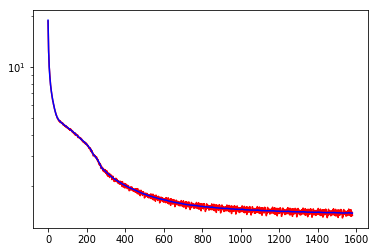

In [935]:
print("Likelihood by iteration.")

plt.yscale('log')
plt.plot(range(0, len(train_losses)), train_losses, 'r',
         range(0, len(validate_losses)), validate_losses, 'b')

In [936]:
print("Result on test (negative log likelyhood): ", test_loss)

Result on test (negative log likelyhood):  1.2975021600723267


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:35: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



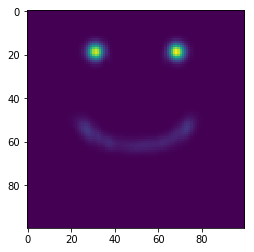

In [937]:
d = np.linspace(-4, 4, 100)
samples = np.array(np.meshgrid(d, d)).T.reshape([-1, 2])
samples = torch.from_numpy(samples).float()
pdf = model(samples).detach().numpy().reshape(100, 100)
plt.imshow(np.rot90(pdf, 1))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



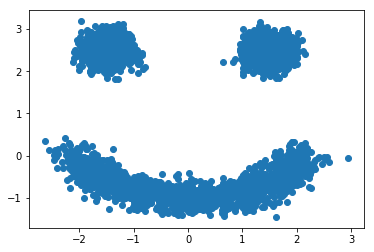

In [942]:
sample = Uniform(torch.tensor([0.0]), torch.tensor([1.0])).rsample((5000, 2))
xs, ys = model.invert(sample)
plt.figure()
plt.scatter(xs, ys)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



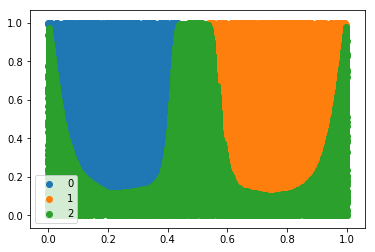

In [943]:
xs = torch.from_numpy(data_x).float()
z1, z2 = model.latent(xs)
z1 = z1.detach().numpy()
z2 = z2.detach().numpy()
plt.figure()
plt.scatter(z1[data_y == 0], z2[data_y == 0], label='0')
plt.scatter(z1[data_y == 1], z2[data_y == 1], label='1')
plt.scatter(z1[data_y == 2], z2[data_y == 2], label='2')
plt.legend()